# A Simple Time Series Analysis Of The S&P 500 Index

This notebook presents some basic ideas from time series analysis applied to stock market data, specificially the daily closing value of the S&P 500 index from 1950 up to the present day.

The first thing we need to do is import the data set.  This was downloaded as a CSV file from Yahoo Finance and is available in the "data" folder.

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sb
sb.set_style('darkgrid')

path = os.getcwd() + '\data\stock_data.csv'
stock_data = pd.read_csv(path)
stock_data['Date'] = stock_data['Date'].convert_objects(convert_dates='coerce')
stock_data = stock_data.sort_index(by='Date')
stock_data = stock_data.set_index('Date')
stock_data.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,16.66
1950-01-04,16.85,16.85,16.85,16.85,1890000,16.85
1950-01-05,16.93,16.93,16.93,16.93,2550000,16.93
1950-01-06,16.98,16.98,16.98,16.98,2010000,16.98
1950-01-09,17.08,17.08,17.08,17.08,2520000,17.08


The first thing to do is just plot the data and see what it looks like.  We'll target the closing price after each day.

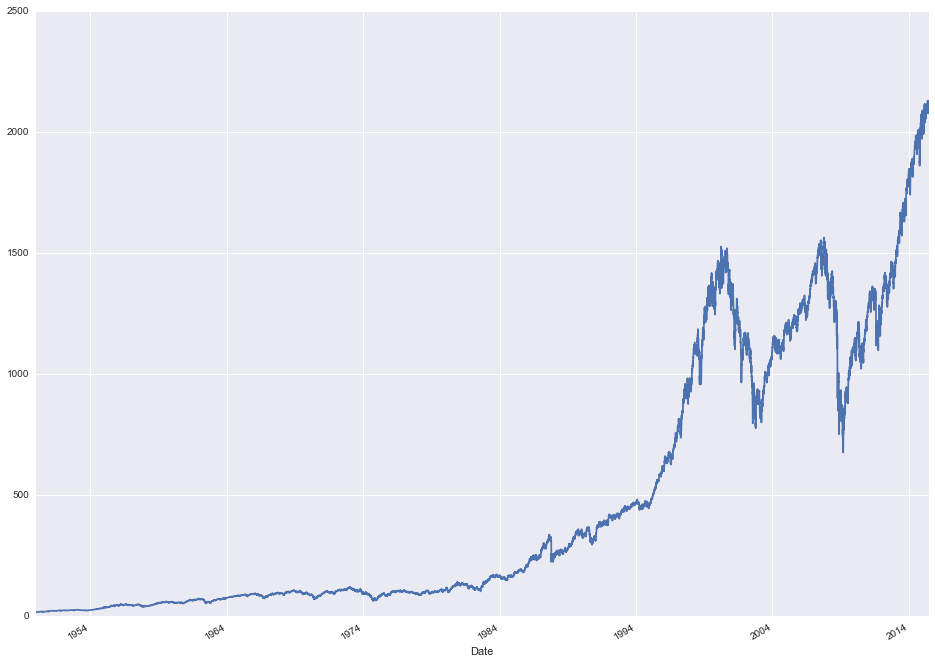

In [2]:
stock_data['Close'].plot(figsize=(16, 12))

The data is clearly non-stationary as we can see it's trending up over time.  we can create a first difference of the original series to attempt to make it stationary.

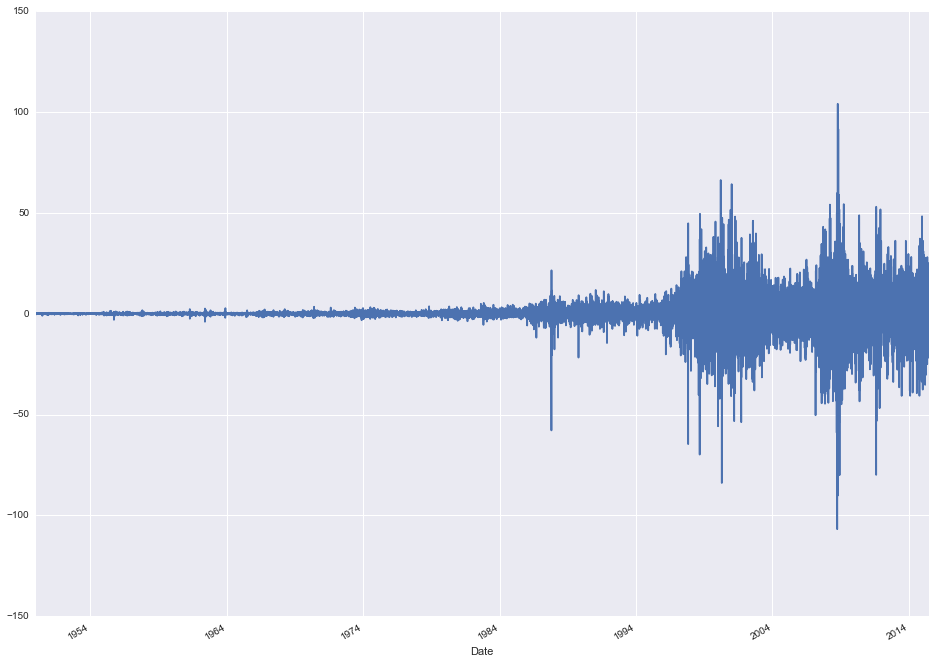

In [3]:
stock_data['First Difference'] = stock_data['Close'] - stock_data['Close'].shift()
stock_data['First Difference'].plot(figsize=(16, 12))

Notice how the magnitude of the variance from day to day still increases over time.  The data is also exponentially increasing,  making variations in earlier observations difficult to see.  we can fix this by applying a log transform to the data.

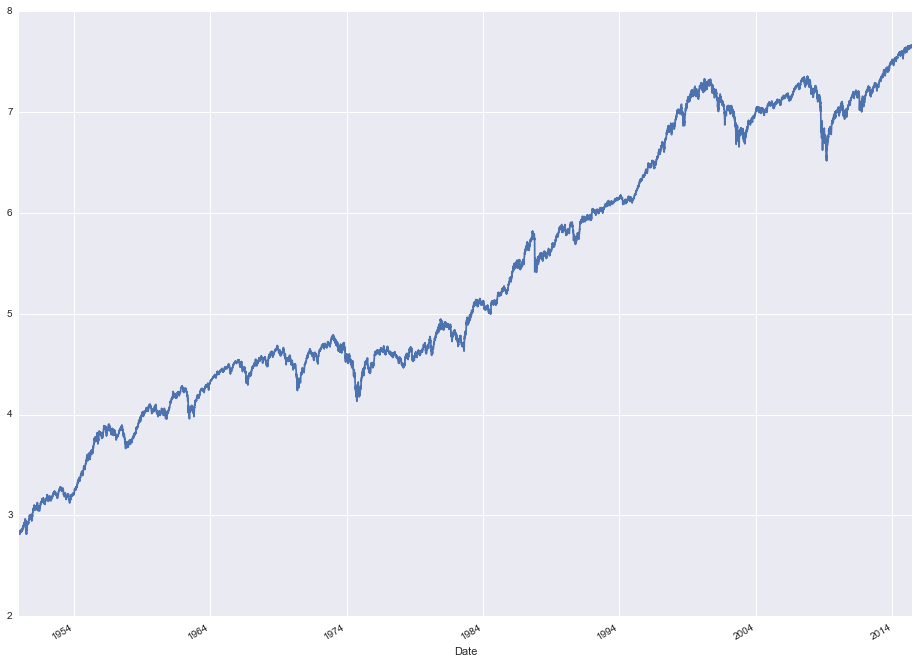

In [4]:
stock_data['Natural Log'] = stock_data['Close'].apply(lambda x: np.log(x))
stock_data['Natural Log'].plot(figsize=(16, 12))

So that gives us the original closing price with a log transform applied to "flatten" the data from an exponential curve to a linear curve.  Now if we were to compare the variance over time of the original series to the logged series, we can see a clear difference.

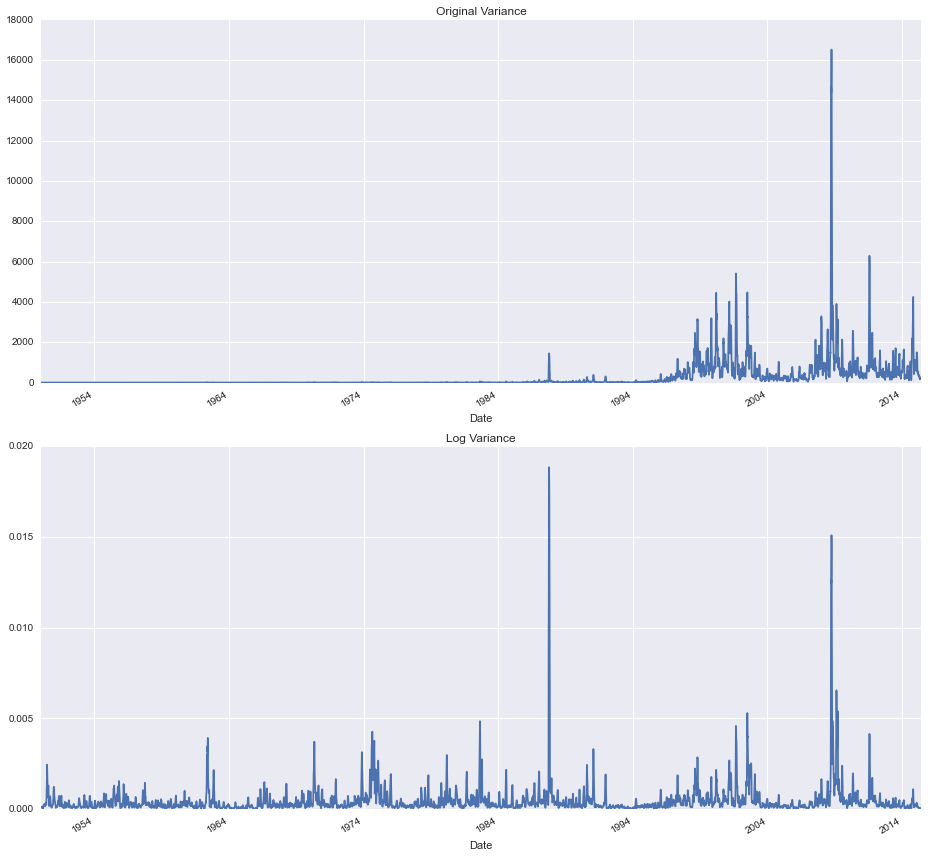

In [5]:
stock_data['Original Variance'] = pd.rolling_var(stock_data['Close'], 30, min_periods=None, freq=None, center=True)
stock_data['Log Variance'] = pd.rolling_var(stock_data['Natural Log'], 30, min_periods=None, freq=None, center=True)

fig, ax = plt.subplots(2, 1, figsize=(13, 12))
stock_data['Original Variance'].plot(ax=ax[0], title='Original Variance')
stock_data['Log Variance'].plot(ax=ax[1], title='Log Variance')
fig.tight_layout()

Observe that in the top graph, we can't even see any of the variations until the late 80s.  In the bottom graph however it's a different story, changes in the value are clearly visible throughout the entire data set.

We can now see a lot more of the variability in the series, but the logged value still isn't stationary.  Let's try a first difference on the logged value of the closing price to even it out.

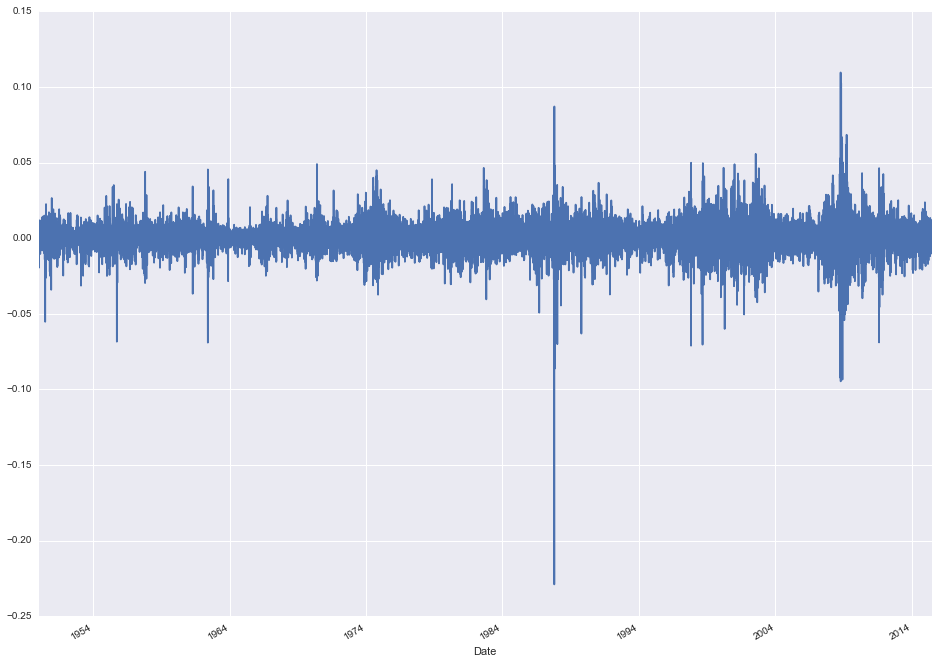

In [6]:
stock_data['Logged First Difference'] = stock_data['Natural Log'] - stock_data['Natural Log'].shift()
stock_data['Logged First Difference'].plot(figsize=(16, 12))

Much better!  We now have a stationary time series model of daily changes to the S&P 500 index. Now let's create some lag variables y(t-1), y(t-2) etc. and examine their relationship to y(t). We'll look at 1 and 2-day lags along with weekly and monthly lags to look for "seasonal" effects.

In [7]:
stock_data['Lag 1'] = stock_data['Logged First Difference'].shift()
stock_data['Lag 2'] = stock_data['Logged First Difference'].shift(2)
stock_data['Lag 5'] = stock_data['Logged First Difference'].shift(5)
stock_data['Lag 30'] = stock_data['Logged First Difference'].shift(30)

One interesting visual way to evaluate the relationship between lagged variables is to do a scatter plot of the original variable vs. the lagged variable and see where the distribution lies.

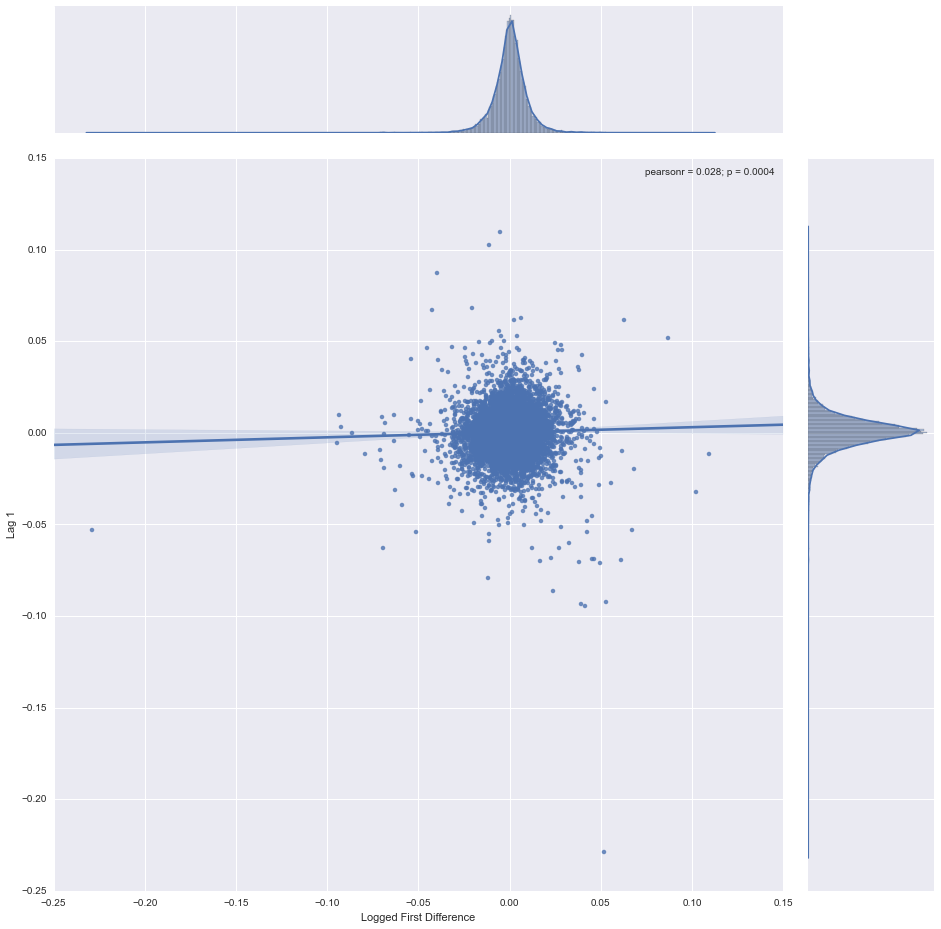

In [8]:
sb.jointplot('Logged First Difference', 'Lag 1', stock_data, kind='reg', size=13)

It probably comes as no surprise that there's very little correlation between the change in value from one day to the next.  The other lagged variables that we created above show similar results.  There could be a relationship to other lag steps that we haven't tried, but it's impractical to test every possible lag value manually.  Fortunately there is a class of functions that can systematically do this for us.

In [9]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

lag_correlations = acf(stock_data['Logged First Difference'].iloc[1:])
lag_partial_correlations = pacf(stock_data['Logged First Difference'].iloc[1:])

The auto-correlation function computes the correlation between a variable and itself at each lag step up to some limit (in this case 40).  The partial auto-correlation function computes the correlation at each lag step that is NOT already explained by previous, lower-order lag steps.  We can plot the results to see if there are any significant correlations.

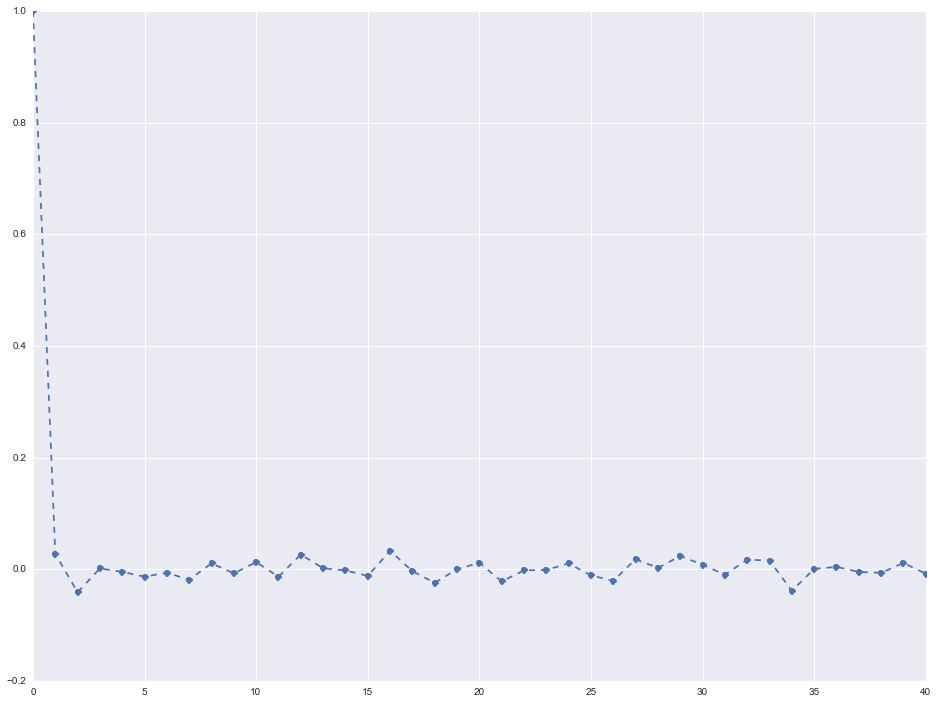

In [10]:
fig, ax = plt.subplots(figsize=(16,12))
ax.plot(lag_correlations, marker='o', linestyle='--')

The auto-correlation and partial-autocorrelation results are very close to each other (I only plotted the auto-correlation results above).  What this shows is that there is no significant correlation between the value at time t and at any time prior to t up to 40 steps behind.  In order words, the series is a random walk (pretty much expected with stock data).  Another interesting technique we can try is a decomposition.  This is a technique that attempts to break down a time series into trend, seasonal, and residual factors.

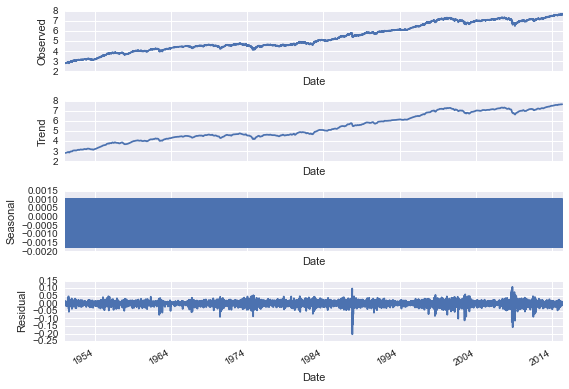

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(stock_data['Natural Log'], model='additive', freq=30)
fig = plt.figure()
fig = decomposition.plot()

Unfortunately this one can't be resized in-line but you can still get an idea of what it's doing.  Since there isn't any true cycle in this data the visualization doesn't come out too well.  Here's an example from the statsmodels documentation that looks more interesting.

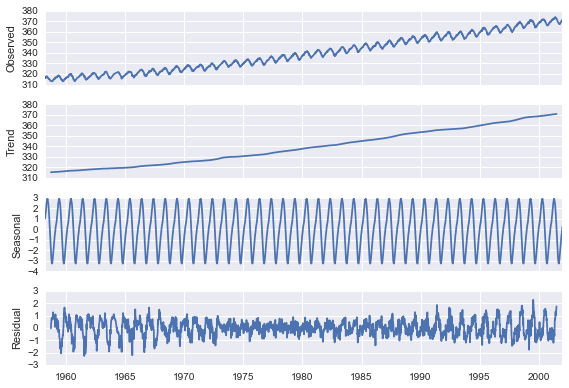

In [12]:
co2_data = sm.datasets.co2.load_pandas().data
co2_data.co2.interpolate(inplace=True)
result = sm.tsa.seasonal_decompose(co2_data.co2)
fig = plt.figure()
fig = result.plot()

Although we're not likely to get much value out of fitting a time series model based solely on lagged data points in this instance, we can still try fitting some ARIMA models and see what we get.  Let's start with a simple moving average model.

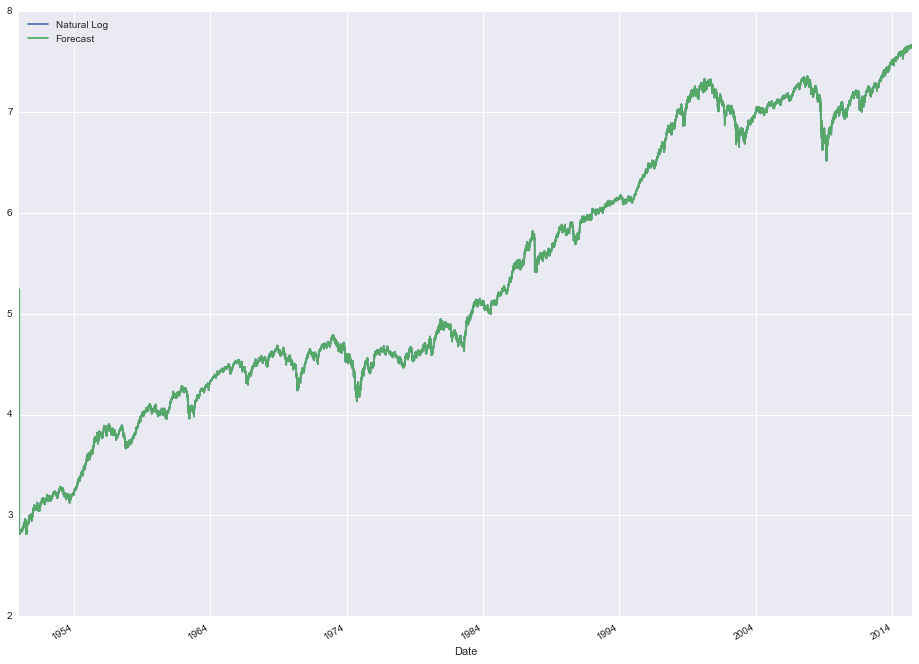

In [13]:
model = sm.tsa.ARIMA(stock_data['Natural Log'].iloc[1:], order=(1, 0, 0))
results = model.fit(disp=-1)
stock_data['Forecast'] = results.fittedvalues
stock_data[['Natural Log', 'Forecast']].plot(figsize=(16, 12))

Although it appears like the model is performing very well (the lines are almost indistinguishable after all), remember that we used the un-differenced series!  The value only fluctuates a small percentage day-to-day relative to the total absolute value.  What we really want is to predict the first difference, or the day-to-day moves.  We can either re-run the model using the differenced series, or add an "I" term to the ARIMA model (resulting in a (1, 1, 0) model) which should accomplish the same thing.  Let's try using the differenced series.

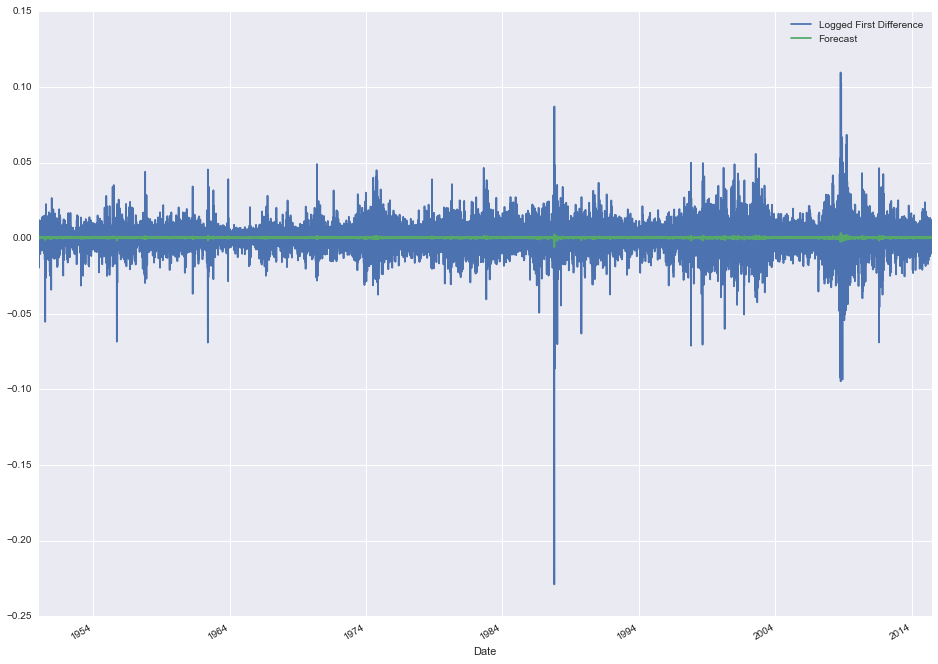

In [14]:
model = sm.tsa.ARIMA(stock_data['Logged First Difference'].iloc[1:], order=(1, 0, 0))
results = model.fit(disp=-1)
stock_data['Forecast'] = results.fittedvalues
stock_data[['Logged First Difference', 'Forecast']].plot(figsize=(16, 12))

We can kind of see that the variations predicted by the model are much smaller than the true variations, but hard to observe when we're looking at the entire 60+ years of history.  What if we take just a small slice of the data?

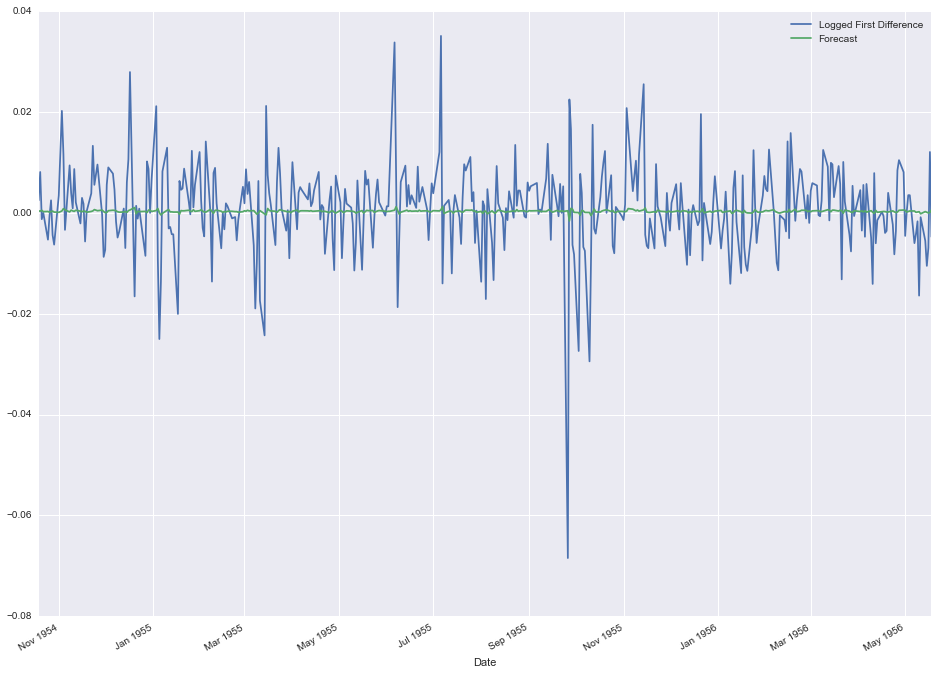

In [15]:
stock_data[['Logged First Difference', 'Forecast']].iloc[1200:1600, :].plot(figsize=(16, 12))

Now it's pretty obvious that the forecast is way off.  We're predicting tiny little variations relative to what is actually happening day-to-day.  Again, this is more of less expected with a simple moving average model of a random walk time series.  There's not enough information from the previous days to accurately forcast what's going to happen the next day.

A moving average model doesn't appear to do so well.  What about an exponential smoothing model?  Exponential smoothing spreads out the impact of previous values using an exponential weighting, so things that happened more recently are more impactful than things that happened a long time ago.  Maybe this "smarter" form of averaging will be more accurate?

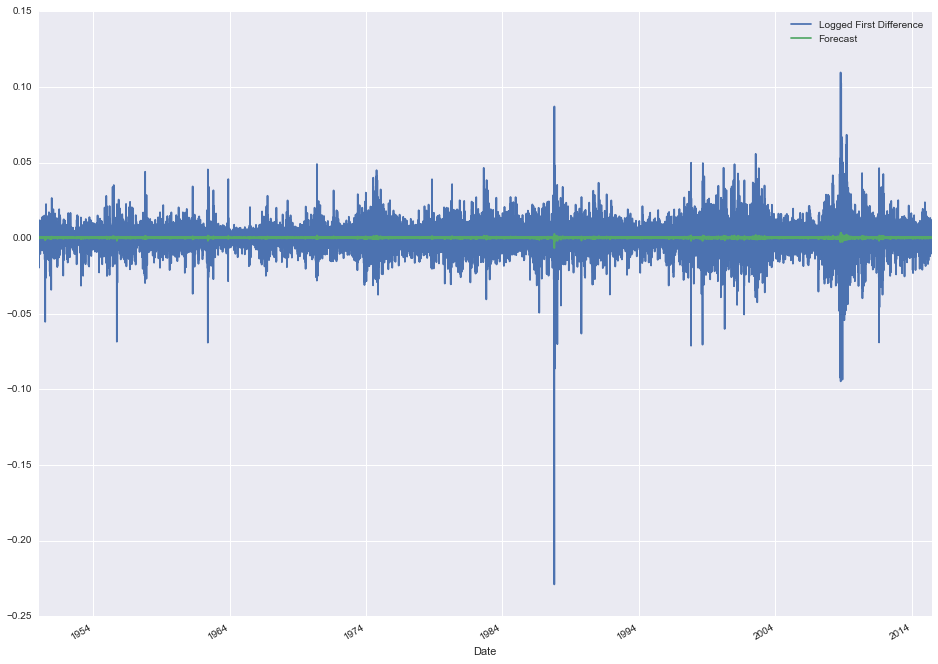

In [16]:
model = sm.tsa.ARIMA(stock_data['Logged First Difference'].iloc[1:], order=(0, 0, 1))
results = model.fit(disp=-1)
stock_data['Forecast'] = results.fittedvalues
stock_data[['Logged First Difference', 'Forecast']].plot(figsize=(16, 12))

You can probably guess the answer...if predicting the stock market were this easy, everyone would be doing it!  Obviously the point of this analysis wasn't to claim that you can predict the market with these techniques, but rather to demonstrate the types of the analysis one might use when breaking down time series data.  Hope you enjoyed it!